# Analysis of the best method: SVR + normalization N(0,1)

In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

from termcolor import colored

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, confusion_matrix

from sklearn.svm import SVR

In [2]:
data = pd.read_csv('winequality.csv', sep=';')

print('Loaded', len(data), 'samples')

Loaded 6497 samples


In [3]:
try:
    data['type'] = data['type'].map(lambda x: 1 if x == 'White' else 0)
    print('\' type \' field is fixed')
except Exception as e:
    print('ERROR:', e)
    pass

' type ' field is fixed


In [4]:
def fix_alcohol_field(s):
    if s.count('.') > 1:
        return None
    else:
        return float(s)

In [5]:
try:
    data['alcohol'] = data['alcohol'].map(fix_alcohol_field)
    print('\' alcohol \' field is fixed')
except Exception as e:
    print('ERROR:', e)
    pass

' alcohol ' field is fixed


In [6]:
data = data.dropna()

print('There are', len(data), 'samples')

There are 6457 samples


In [7]:
keys_list = list(data.keys())
keys_output = ['quality'] # output fields
keys_input = list(set(keys_list) - set(keys_output)) # input fields

In [8]:
def normalize(train_x, test_x, train_y, test_y):
    train_x_norm = np.zeros_like(train_x)
    test_x_norm = np.zeros_like(test_x)
    train_y_norm = train_y.copy()
    test_y_norm = test_y.copy()
    for k in range(len(keys_input)):
        mean = train_x[:,k].mean()
        var = train_x[:,k].var()
        train_x_norm[:,k] = (train_x[:,k] - mean)/var
        test_x_norm[:,k] = (test_x[:,k] - mean)/var
    
    return train_x_norm, test_x_norm, train_y_norm, test_y_norm

In [9]:
results = []
kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(data.as_matrix()):
    train_x, test_x = data[keys_input].as_matrix()[train_index], data[keys_input].as_matrix()[test_index]
    train_y, test_y = data[keys_output].as_matrix()[train_index], data[keys_output].as_matrix()[test_index]
    train_x_norm, test_x_norm, train_y_norm, test_y_norm = normalize(train_x, test_x, train_y, test_y)
    
    model = SVR()
    regressor = GridSearchCV(model, {'C':[1, 10, 100, 1000]}, verbose=1)
    regressor.fit(train_x_norm, train_y_norm)
    
    prediction = np.round(regressor.predict(test_x_norm))
    results.append((test_y_norm, prediction))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   26.7s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   26.3s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   26.7s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   26.3s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   25.9s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   26.8s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   26.7s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   26.3s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   25.5s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   25.9s finished


In [13]:
mae_list = []

for r in results:
    mae_list.append(mean_absolute_error(r[0], r[1]))

print('Max error =', np.max(mae_list))
print('Min error =', np.min(mae_list))
print('Avg error =', np.mean(mae_list))
print('Var of error =', np.var(mae_list))

Max error = 0.47368421052631576
Min error = 0.4232558139534884
Avg error = 0.45191278469772234
Var of error = 0.0002792477258425143


<IPython.core.display.Javascript object>


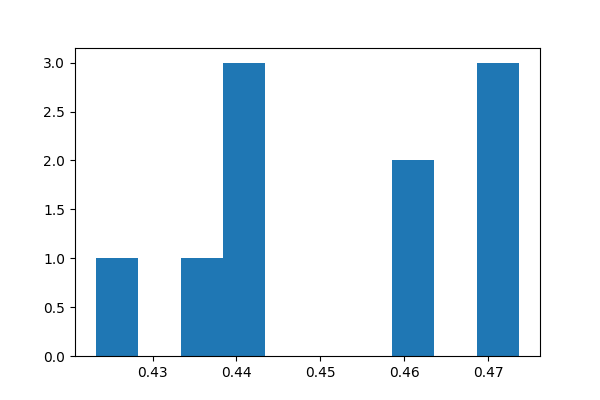

In [12]:
plt.figure(figsize=(6,4), num='Histogram of MAE for KFold')
plt.hist(mae_list);

In [16]:
def hist_error(conf_matrix):
    r, c = conf_matrix.shape[:2]
    hist = [0]*np.max([r,c])
    for i in range(r):
        for j in range(c):
            hist[np.abs(i-j)] += conf_matrix[i,j]
    
    return hist

In [17]:
hist_mae = np.zeros((7,)) # maximum distance between predicted and real values is 7
for r in results:
    hist_mae[:len(np.unique(r[0]))] += np.array(hist_error(confusion_matrix(r[0], r[1])))
hist_mae /= 10.

<IPython.core.display.Javascript object>


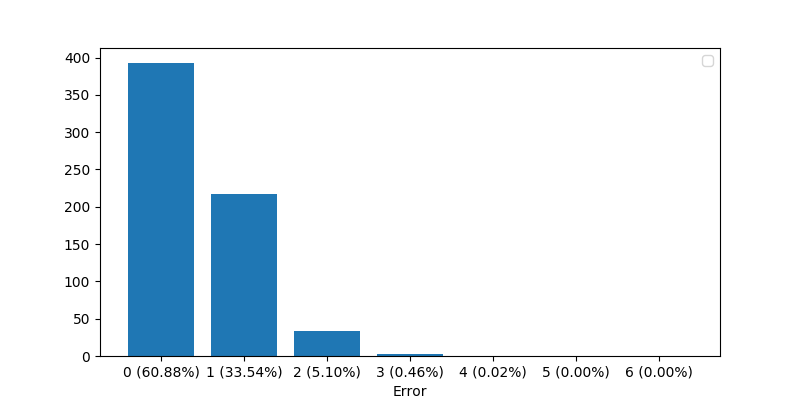

No handles with labels found to put in legend.


In [18]:
plt.figure(figsize=(8,4), num='Mean histogram of error')
plt.xlabel('Error')
plt.bar(range(7), hist_mae);
plt.xticks(range(7), [str(p)+' ({:.2f}%)'.format(100*i/np.sum(hist_mae)) for p,i in enumerate(hist_mae)])
plt.legend();

In [21]:
6088/(6088+3354)

0.6447786485914001